<a href="https://colab.research.google.com/github/OleksandraOst/hello-world/blob/master/SEP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors
import torch
import time
import copy
import json
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
from operator import itemgetter
from scipy.optimize import curve_fit
from scipy.integrate import quad
from google.colab import files
from datetime import datetime
from random import random
from random import seed
from numpy import asarray
from numpy import savez_compressed
from numpy import load
from zipfile import ZipFile
from torch import cuda
import scipy.stats as scs

In [30]:
np.random.seed(42)

POISSON_PARAMETER = 100
NUMBER_OF_SAMPLES = 12600
NUMBER_OF_TEMPLATE = 1
DIM_OF_MATRIX = 28

In [31]:
matrix_tempalte_trial = POISSON_PARAMETER * np.ones((DIM_OF_MATRIX, DIM_OF_MATRIX), dtype = float)

A_entries=[]
B_entries=[]

for y in range(1300):

# Dices the samples
  #curr_T = np.random.normal(loc=matrix_tempalte_trial,scale=np.sqrt(matrix_tempalte_trial),size=None)    
  curr_A_entries = np.random.poisson(matrix_tempalte_trial)
  curr_B_entries = np.random.poisson(matrix_tempalte_trial)
  A_entries.append(curr_A_entries)
  B_entries.append(curr_B_entries)  
  #print(y)

print(np.shape(A_entries))
#print(A_entries[1])

C_entries = []
D_entries = []

for i in range(1):
  C_entry = []
  D_entry = []
  for y in range(12600):
    curr_C = np.random.poisson(A_entries[i])
    curr_D = np.random.poisson(B_entries[i])

    C_entry.append(curr_C)
    D_entry.append(curr_D)

  C_entries.append(C_entry)
  D_entries.append(D_entry)
  print(i)
print(np.shape(C_entries))

(1300, 28, 28)
0
(1, 12600, 28, 28)


####Signal Generation

X ticks are:  [ 30000.  35000.  40000.  45000.  50000.  55000.  60000.  65000.  70000.
  75000.  80000.  85000.  90000.  95000. 100000. 105000. 110000. 115000.
 120000. 125000. 130000. 135000. 140000. 145000. 150000. 155000. 160000.
 165000. 170000.] 

Y ticks are:  [ 10000.  15000.  20000.  25000.  30000.  35000.  40000.  45000.  50000.
  55000.  60000.  65000.  70000.  75000.  80000.  85000.  90000.  95000.
 100000. 105000. 110000. 115000. 120000. 125000. 130000. 135000. 140000.
 145000. 150000.] 


Original background base template min value:  67
Original background base template max value:  130
Original background base template max/min value:  1.9402985074626866 

Rescale IS REQUESTED.
Rescaling imported background base template to be between 100 to 200...
Imported background template min value:  100.0
Imported background template max value:  200.0
Imported background template max/min value:  2.0 

This is a signal Number 0 in a Rectangle Shape.
Its MEAN values are:  (60000, 40000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in double_scalars


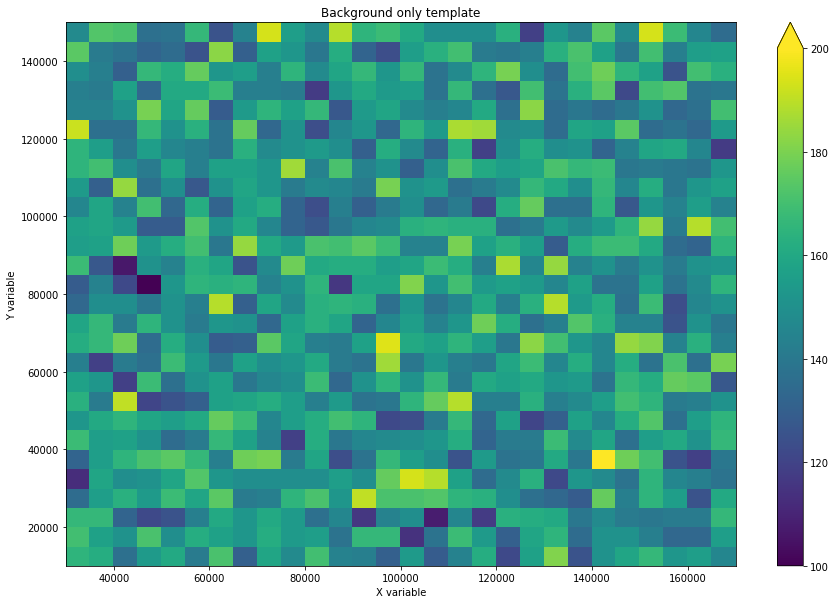

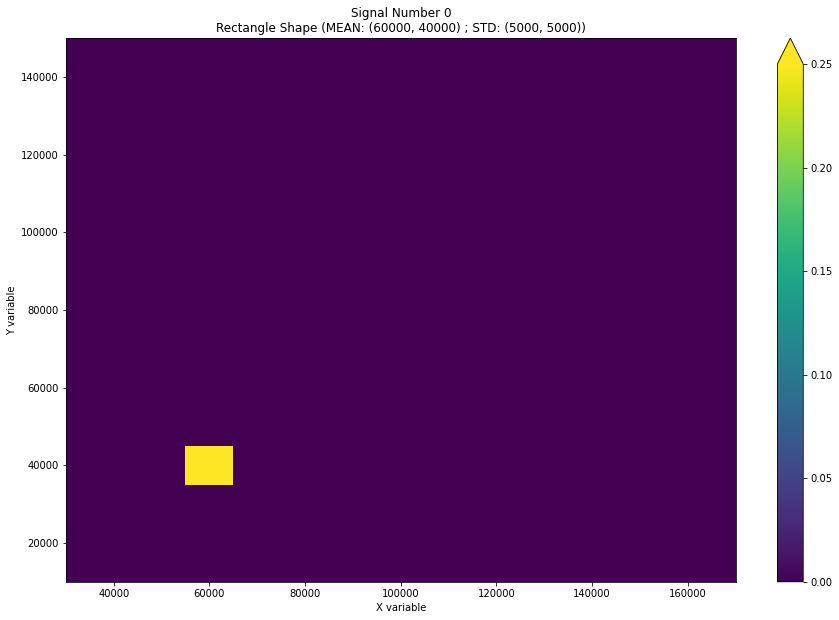

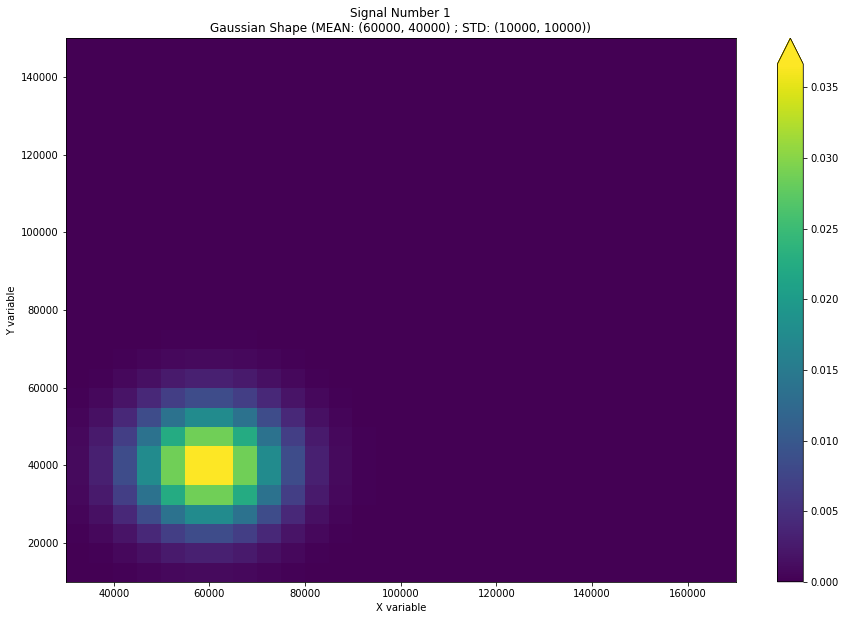

In [32]:

A_edges = [[ 30000.,  35000.,  40000.,  45000.,  50000.,  55000.,  60000. , 65000.,  70000.,
  75000.,  80000.,  85000.,  90000. , 95000., 100000. ,105000. ,110000., 115000.,
 120000. ,125000., 130000., 135000., 140000., 145000., 150000., 155000., 160000.,
 165000., 170000.]  ,[ 10000.,  15000.,  20000.,  25000. , 30000. , 35000. , 40000. , 45000.,  50000.,
  55000.,  60000. , 65000.,  70000.,  75000. , 80000.  ,85000. , 90000.,  95000.,
 100000., 105000. ,110000., 115000., 120000., 125000., 130000., 135000. ,140000.,
 145000., 150000.]]


np.savez('Template_B.npz', entries = B_entries, 
         edges = A_edges)

background_data = np.copy('Template_B.npz')




# Sets the X and Y axes
X_axis = np.copy(A_edges[0])
Y_axis = np.copy(A_edges[1])

# Prints the data ticks
print('X ticks are: ', X_axis, '\n')
print('Y ticks are: ', Y_axis, '\n\n')

# Sets the X and Y axes for the no-frame case
X_axis_no_frm = np.copy(X_axis[1:X_axis.shape[0] - 1])
Y_axis_no_frm = np.copy(Y_axis[1:Y_axis.shape[0] - 1])



BACKGROUND_BASE_TEMPLATE = background_data
BACKGROUND_BASE_TEMPLATE_ENTRIES = B_entries[0]
SCALE_BACKGROUND_TEMPLATE = True
REQ_BACKGROUND_TEMPLATE_MIN_BIN_ENTRY = 100
REQ_BACKGROUND_TEMPLATE_MAX_BIN_ENTRY = 200

NUM_OF_DIFFERENT_SIGNAL_DENSITY_SHAPES = 2

BASE_SHAPE = 'Base Shape'
GAUSSIAN_SHAPE = 'Gaussian Shape'
RECTANGLE_SHAPE = 'Rectangle Shape'
MEAN_VALUES = 'Mean Values'
STD_VALUES = 'STD Values'

NUM_OF_STDS_FOR_GAUSSIAN_SIGMA = 1.0 # Num of std's away from guassian's mean to count sqrt(B) (in order to get 1 sigma)

SIGNAL_DENSITY_SHAPES_PROPERTIES = [{} for i in range(NUM_OF_DIFFERENT_SIGNAL_DENSITY_SHAPES)]
SIGNAL_DENSITY_SHAPES_PROPERTIES[0] = {BASE_SHAPE: RECTANGLE_SHAPE,
                                       MEAN_VALUES: (60000, 40000), # MeV
                                       STD_VALUES: (5000, 5000)} # MeV
SIGNAL_DENSITY_SHAPES_PROPERTIES[1] = {BASE_SHAPE: GAUSSIAN_SHAPE,
                                       MEAN_VALUES: (60000, 40000), # MeV
                                       STD_VALUES: (10000, 10000)} # MeV 




def PrintTemplateMinMaxAndRatio(template_to_inspect, template_to_inspect_title = ''):

  print(template_to_inspect_title + ' min value: ', np.min(template_to_inspect))
  print(template_to_inspect_title + ' max value: ', np.max(template_to_inspect))
  print(template_to_inspect_title + ' max/min value: ', np.max(template_to_inspect)/np.min(template_to_inspect), '\n')

  return

def ScaleTemplateBetweenMinMaxBinEntry(base_template, new_min_entry, new_max_entry):

  # Calculates the current min and max bin entries
  curr_min_entry = np.min(base_template)
  curr_max_entry = np.max(base_template)

  # Rescale the template to have the new values of min and max bin entries
  base_template_copy = np.copy(base_template)
  base_template_copy = new_min_entry*(base_template_copy - curr_min_entry)/(curr_max_entry - curr_min_entry) + (new_max_entry - new_min_entry)

  return base_template_copy


def GetBinIndexByLeftEdgeValue(left_limit_value, bins_edges):
  return np.where(bins_edges == left_limit_value)[0][0]

def GetBinEdges(bin_index, bins_edges):

  bin_left_edge = bins_edges[bin_index]
  bin_right_edge = bins_edges[bin_index + 1]

  return bin_left_edge, bin_right_edge

def Gaussian_after_variable_change(x):
  return (1/np.sqrt(np.pi)) * np.exp(-x**2)

def Fill1DHistogramByGaussian(gaussian_mean, gaussian_std, axis_edges):

  gaussian_entries = np.zeros(axis_edges.shape[0] - 1)

  # Calculates the gaussian contribution in the given axis
  for curr_axis_index in range(gaussian_entries.shape[0]):

    # Gets the current bin edges
    curr_bin_left_edge, curr_bin_right_edge = GetBinEdges(curr_axis_index, axis_edges)

    # Sets the lower and upper integral limits
    #print(gaussian_std)
    lower_integral_limit = (curr_bin_left_edge - gaussian_mean)/(np.sqrt(2) * gaussian_std)
    upper_integral_limit = (curr_bin_right_edge - gaussian_mean)/(np.sqrt(2) * gaussian_std)
    #print(lower_integral_limit, upper_integral_limit)
    # Calculates the current contribution
    gaussian_entries[curr_axis_index], _ = quad(Gaussian_after_variable_change, lower_integral_limit, upper_integral_limit) 
    print('norm gauss entry =',gaussian_entries[curr_axis_index],' in bin between the edges =', curr_bin_left_edge,' and ', curr_bin_right_edge)
  return gaussian_entries

  # Prints the min max values of the input template for background
PrintTemplateMinMaxAndRatio(BACKGROUND_BASE_TEMPLATE_ENTRIES, template_to_inspect_title = 'Original background base template')

# Checks if a rescaling is needed
if (SCALE_BACKGROUND_TEMPLATE == False):
  
  print('Rescale is NOT REQUESTED.')
  background_only_template = np.copy(BACKGROUND_BASE_TEMPLATE_ENTRIES)
else:
  
  print('Rescale IS REQUESTED.')
  print('Rescaling imported background base template to be between ' + 
        str(REQ_BACKGROUND_TEMPLATE_MIN_BIN_ENTRY) + ' to ' + str(REQ_BACKGROUND_TEMPLATE_MAX_BIN_ENTRY) + '...')
  
  background_only_template = ScaleTemplateBetweenMinMaxBinEntry(BACKGROUND_BASE_TEMPLATE_ENTRIES, 
                                                                REQ_BACKGROUND_TEMPLATE_MIN_BIN_ENTRY, REQ_BACKGROUND_TEMPLATE_MAX_BIN_ENTRY)

# Prints the min max values of background template which will be used
PrintTemplateMinMaxAndRatio(background_only_template, template_to_inspect_title = 'Imported background template')

# Initializes the array of the signals shapes densities and the array of the signal region indices in each axis
arr_signals_shapes_densities = []
arr_X_axis_signal_low_high_indices = []
arr_Y_axis_signal_low_high_indices = []

# Creates the signals shapes densities
for curr_signal_shape_index in range(NUM_OF_DIFFERENT_SIGNAL_DENSITY_SHAPES):

  # Gets the current signal shape properties
  curr_signal_shape_properties = SIGNAL_DENSITY_SHAPES_PROPERTIES[curr_signal_shape_index]

  print('This is a signal Number ' + str(curr_signal_shape_index) + ' in a ' + curr_signal_shape_properties[BASE_SHAPE] + '.')
  print('Its MEAN values are: ', curr_signal_shape_properties[MEAN_VALUES], '.')
  print('Its STD values are: ', curr_signal_shape_properties[STD_VALUES], '.')
  
  curr_signal_shape_mean_X = curr_signal_shape_properties[MEAN_VALUES][0]
  curr_signal_shape_std_X = curr_signal_shape_properties[STD_VALUES][0]
  curr_signal_shape_mean_Y = curr_signal_shape_properties[MEAN_VALUES][1]
  curr_signal_shape_std_Y = curr_signal_shape_properties[STD_VALUES][1]

  # Creates an empty template for the current signal shape density
  curr_signal_shape_template = np.zeros_like(background_only_template)

  # Checks if the current signal shape is a rectangle or a guassian
  if (curr_signal_shape_properties[BASE_SHAPE] == RECTANGLE_SHAPE):

    # If it is rectangle
    # Get the indices of the signal region
    X_axis_signal_low_index = GetBinIndexByLeftEdgeValue(curr_signal_shape_mean_X - curr_signal_shape_std_X, X_axis)
    X_axis_signal_high_index = GetBinIndexByLeftEdgeValue(curr_signal_shape_mean_X + curr_signal_shape_std_X, X_axis)

    Y_axis_signal_low_index = GetBinIndexByLeftEdgeValue(curr_signal_shape_mean_Y - curr_signal_shape_std_Y, Y_axis)
    Y_axis_signal_high_index = GetBinIndexByLeftEdgeValue(curr_signal_shape_mean_Y + curr_signal_shape_std_Y, Y_axis)

    # Fills the rectangle such that the area of it is equal to 1
    total_rectangle_area_before_renormalization = ((2 * curr_signal_shape_std_X)/(X_axis[1] - X_axis[0])) * ((2 * curr_signal_shape_std_Y)/(Y_axis[1] - Y_axis[0]))
    
    curr_signal_shape_template[X_axis_signal_low_index:X_axis_signal_high_index, 
                               Y_axis_signal_low_index:Y_axis_signal_high_index] = 1/total_rectangle_area_before_renormalization
  
  elif (curr_signal_shape_properties[BASE_SHAPE] == GAUSSIAN_SHAPE):

    # If it is a gaussian
    # Get the indices of the signal region
    X_axis_signal_low_index = GetBinIndexByLeftEdgeValue(curr_signal_shape_mean_X - NUM_OF_STDS_FOR_GAUSSIAN_SIGMA * curr_signal_shape_std_X, X_axis)
    X_axis_signal_high_index = GetBinIndexByLeftEdgeValue(curr_signal_shape_mean_X + NUM_OF_STDS_FOR_GAUSSIAN_SIGMA * curr_signal_shape_std_X, X_axis)

    Y_axis_signal_low_index = GetBinIndexByLeftEdgeValue(curr_signal_shape_mean_Y - NUM_OF_STDS_FOR_GAUSSIAN_SIGMA * curr_signal_shape_std_Y, Y_axis)
    Y_axis_signal_high_index = GetBinIndexByLeftEdgeValue(curr_signal_shape_mean_Y + NUM_OF_STDS_FOR_GAUSSIAN_SIGMA * curr_signal_shape_std_Y, Y_axis)

    # Gets the gaussian contributions in each axes
    signal_x_axis_contributions = Fill1DHistogramByGaussian(curr_signal_shape_mean_X, curr_signal_shape_std_X, X_axis)
    signal_y_axis_contributions = Fill1DHistogramByGaussian(curr_signal_shape_mean_Y, curr_signal_shape_std_Y, Y_axis)

    # Fills the signal only template
    for curr_X_index in range(signal_x_axis_contributions.shape[0]):
      for curr_Y_index in range(signal_y_axis_contributions.shape[0]): 

        # Sets the value of the current bin
        curr_signal_shape_template[curr_X_index, curr_Y_index] = signal_x_axis_contributions[curr_X_index] * signal_y_axis_contributions[curr_Y_index]

  print('The total AREA of the current signal is: ', np.sum(curr_signal_shape_template))

  PrintTemplateMinMaxAndRatio(curr_signal_shape_template, template_to_inspect_title = 'Signal template number ' + str(curr_signal_shape_index))

  # Saves the current signal shape
  arr_signals_shapes_densities.append(curr_signal_shape_template)

  # Saves the current signal low and high indices in each axis
  arr_X_axis_signal_low_high_indices.append([X_axis_signal_low_index, X_axis_signal_high_index])
  arr_Y_axis_signal_low_high_indices.append([Y_axis_signal_low_index, Y_axis_signal_high_index])

# Plots the background and signal templates
plt.rcParams["figure.figsize"]=15,10

# Plots first the background
_, ax = plt.subplots(1)
pcm = ax.pcolor(X_axis, Y_axis, np.transpose(background_only_template),  
                  cmap= 'viridis')  
plt.colorbar(pcm, ax=ax, extend='max')
plt.title('Background only template')
plt.xlabel('X variable')
plt.ylabel('Y variable')

plt.savefig('Background_raw_template.png')
plt.show()

# Then plots all the signal shapes
for curr_signal_shape_index in range(NUM_OF_DIFFERENT_SIGNAL_DENSITY_SHAPES):

  _, ax = plt.subplots(1)
  pcm = ax.pcolor(X_axis, Y_axis, np.transpose(arr_signals_shapes_densities[curr_signal_shape_index]),  
                  cmap= 'viridis')  
  plt.colorbar(pcm, ax=ax, extend='max')
  plt.title('Signal Number ' + str(curr_signal_shape_index) + '\n' + 
            SIGNAL_DENSITY_SHAPES_PROPERTIES[curr_signal_shape_index][BASE_SHAPE] + 
            ' (MEAN: ' + str(SIGNAL_DENSITY_SHAPES_PROPERTIES[curr_signal_shape_index][MEAN_VALUES]) +
            ' ; STD: ' + str(SIGNAL_DENSITY_SHAPES_PROPERTIES[curr_signal_shape_index][STD_VALUES]) + ')')
  plt.xlabel('X variable')
  plt.ylabel('Y variable')

  plt.savefig('Signa_shape_number_' + str(curr_signal_shape_index) + '.png')
  plt.show()


#### Add signal to B


In [33]:
B_five_sigma = []
B_three_sigma = []
B_four_sigma = []
B_two_sigma = []
B_signal = []
 
for i in range(1300):
  curr_signal_B = np.sqrt(np.sum(B_entries[i][arr_X_axis_signal_low_high_indices[curr_signal_shape_index][0]:
                                                                                          arr_X_axis_signal_low_high_indices[curr_signal_shape_index][1],
                                                                                          arr_Y_axis_signal_low_high_indices[curr_signal_shape_index][0]:
                                                                                          arr_Y_axis_signal_low_high_indices[curr_signal_shape_index][1]]))
 
  
  curr_B_signal_five_sigma = (curr_signal_B * 5 * arr_signals_shapes_densities[1]) + B_entries[i]
 
  B_five_sigma.append(curr_B_signal_five_sigma)
 
  curr_B_signal_three_sigma = (curr_signal_B * 3 * arr_signals_shapes_densities[1]) + B_entries[i]
 
  B_three_sigma.append(curr_B_signal_three_sigma)
 
  curr_B_signal_four_sigma = (curr_signal_B * 4 * arr_signals_shapes_densities[1]) + B_entries[i]
 
  B_four_sigma.append(curr_B_signal_four_sigma)
 
  curr_B_signal_two_sigma = (curr_signal_B * 2 * arr_signals_shapes_densities[1]) + B_entries[i]
 
  B_two_sigma.append(curr_B_signal_two_sigma)
  
  curr_B_signal = (curr_signal_B * arr_signals_shapes_densities[1])+ B_entries[i]
 
 
  B_signal.append(curr_B_signal)
 
print(np.shape(B_two_sigma))
 
print(np.shape(B_signal))

(1300, 28, 28)
(1300, 28, 28)


#### Separation

In [ ]:
sep_DA_wo = []
sep_DB_wo = []
sep_DA_two = []
sep_DB_two = []
sep_DA_three = []
sep_DB_three = []
sep_DA_four =[]
sep_DB_four = []
sep_DA_five = []
sep_DB_five = []

sep_DA_wo_next = []
sep_DA_two_next = []
sep_DA_four_next = []
sep_DA_five_next = []
sep_DA_three_next = []

def CalculateNSigmaavg(arrOneEntries, arrTwoEntries):

  arrDenominator = np.sqrt(arrTwoEntries)
  arrNumerator = np.subtract(arrOneEntries,arrTwoEntries)

  arrNSigma = (np.divide(arrNumerator, arrDenominator))
  arrNSigma = np.mean(arrNSigma)
  return arrNSigma

for i in range(50):
  C_entries = []
  D_entries = []
  D_five = []
  D_four = []
  D_three = []
  D_two = []
  D_signal = []

  NS_CA = []
  NS_DA_wo = []
  NS_DB_wo = []
  NS_DA_five = []
  NS_DB_five = []
  NS_DA_four = []
  NS_DB_four = []
  NS_DA_three = []
  NS_DB_three = []
  NS_DA_two = []
  NS_DB_two = []
  NS_DA_signal = []
  NS_DB_signal = []


  for y in range(12600):
    curr_C = np.random.poisson(np.random.normal(loc=A_entries[i], scale=np.sqrt(A_entries[i]),size = None))
    C_entries.append(curr_C)

    curr_D = np.random.poisson(np.random.normal(loc=B_entries[i], scale=np.sqrt(B_entries[i]),size = None))
    D_entries.append(curr_D)

    curr_D_five = np.random.poisson(np.random.normal(loc=B_five_sigma[i], scale=np.sqrt(B_five_sigma[i]),size = None))
    D_five.append(curr_D_five)

    curr_D_four = np.random.poisson(np.random.normal(loc=B_four_sigma[i], scale=np.sqrt(B_four_sigma[i]),size = None))
    D_five.append(curr_D_five)

    curr_D_three = np.random.poisson(np.random.normal(loc=B_three_sigma[i], scale=np.sqrt(B_three_sigma[i]),size = None))
    D_three.append(curr_D_three)
    
    curr_D_two = np.random.poisson(np.random.normal(loc=B_two_sigma[i], scale=np.sqrt(B_two_sigma[i]),size = None))
    D_two.append(curr_D_two)

    curr_D_signal = np.random.poisson(np.random.normal(loc=B_signal[i], scale=np.sqrt(B_signal[i]),size = None))
    D_signal.append(curr_D_signal)


    curr_NS_CA = CalculateNSigmaavg(curr_C,A_entries[i])
    curr_NS_DA_wo = CalculateNSigmaavg(curr_D, A_entries[i])
    curr_NS_DB_wo = CalculateNSigmaavg(curr_D, B_entries[i])
    curr_NS_DA_five = CalculateNSigmaavg(curr_D_five, A_entries[i])
    curr_NS_DB_five = CalculateNSigmaavg(curr_D_five, B_five_sigma[i])
    curr_NS_DA_four = CalculateNSigmaavg(curr_D_four, A_entries[i])
    curr_NS_DB_four = CalculateNSigmaavg(curr_D_four, B_four_sigma[i])
    curr_NS_DA_three = CalculateNSigmaavg(curr_D_three, A_entries[i])
    curr_NS_DB_three = CalculateNSigmaavg(curr_D_three, B_three_sigma[i])
    curr_NS_DA_two = CalculateNSigmaavg(curr_D_two, A_entries[i])
    curr_NS_DB_two = CalculateNSigmaavg(curr_D_two, B_two_sigma[i])
    curr_NS_DA_signal = CalculateNSigmaavg(curr_D_signal, A_entries[i])
    curr_NS_DB_signal = CalculateNSigmaavg(curr_D_signal, B_signal[i])


    NS_CA.append(curr_NS_CA)
    NS_DA_wo.append(curr_NS_DA_wo)
    NS_DB_wo.append(curr_NS_DB_wo)
    NS_DA_five.append(curr_NS_DA_five)
    NS_DB_five.append(curr_NS_DB_five)
    NS_DA_four.append(curr_NS_DA_four)
    NS_DB_four.append(curr_NS_DB_four)
    NS_DA_three.append(curr_NS_DA_three)
    NS_DB_three.append(curr_NS_DB_three)
    NS_DA_two.append(curr_NS_DA_two)
    NS_DB_two.append(curr_NS_DB_two)
    NS_DA_signal.append(curr_NS_DA_signal)
    NS_DB_signal.append(curr_NS_DB_signal)
    
  Separation_NS_CA_DA_wo = np.mean(NS_CA) - np.mean(NS_DA_wo)/np.sqrt((np.std(NS_CA)**2 + np.std(NS_DA_wo)**2))
  Separation_NS_CA_DB_wo = np.mean(NS_CA) - np.mean(NS_DB_wo)/np.sqrt(np.std(NS_CA)**2 + np.std(NS_DB_wo)**2)

  Separation_NS_CA_DA_two = np.mean(NS_CA) - np.mean(NS_DA_two)/np.sqrt((np.std(NS_CA)**2 + np.std(NS_DA_two)**2))
  Separation_NS_CA_DB_two = np.mean(NS_CA) - np.mean(NS_DB_two)/np.sqrt(np.std(NS_CA)**2 + np.std(NS_DB_two)**2)

  Separation_NS_CA_DA_three = np.mean(NS_CA) - np.mean(NS_DA_three)/np.sqrt((np.std(NS_CA)**2 + np.std(NS_DA_three)**2))
  Separation_NS_CA_DB_three = np.mean(NS_CA) - np.mean(NS_DB_three)/np.sqrt(np.std(NS_CA)**2 + np.std(NS_DB_three)**2)

  Separation_NS_CA_DA_four = np.mean(NS_CA) - np.mean(NS_DA_four)/np.sqrt((np.std(NS_CA)**2 + np.std(NS_DA_four)**2))
  Separation_NS_CA_DB_four = np.mean(NS_CA) - np.mean(NS_DB_four)/np.sqrt(np.std(NS_CA)**2 + np.std(NS_DB_four)**2)

  Separation_NS_CA_DA_five = np.mean(NS_CA) - np.mean(NS_DA_five)/np.sqrt((np.std(NS_CA)**2 + np.std(NS_DA_five)**2))
  Separation_NS_CA_DB_five = np.mean(NS_CA) - np.mean(NS_DB_five)/np.sqrt(np.std(NS_CA)**2 + np.std(NS_DB_five)**2)

  sep_DA_wo.append(Separation_NS_CA_DA_wo)
  sep_DB_wo.append(Separation_NS_CA_DB_wo)
  sep_DA_two.append(Separation_NS_CA_DA_two)
  sep_DB_two.append(Separation_NS_CA_DB_two)
  sep_DA_three.append(Separation_NS_CA_DA_three)
  sep_DB_three.append(Separation_NS_CA_DB_three)
  sep_DA_four.append(Separation_NS_CA_DA_four)
  sep_DB_four.append(Separation_NS_CA_DB_four)
  sep_DA_five.append(Separation_NS_CA_DA_five)
  sep_DB_five.append(Separation_NS_CA_DB_five)
  

  if i ==10: print(i)
  if i ==50: print(i)
  if i ==100: print(i)
  if i ==200: print(i)
  if i ==300: print(i)
  if i ==500: print(i)
  if i ==800: print(i)
  if i ==1100: print(i)



10


In [ ]:
sep_DA_wo = np.array(sep_DA_wo)

In [ ]:
savez_compressed('sep_DA_wo.npz',sep_DA_wo)
savez_compressed('sep_DA_two.npz',sep_DA_two)
savez_compressed('sep_DA_three.npz',sep_DA_three)
savez_compressed('sep_DA_four.npz',sep_DA_four)
savez_compressed('sep_DA_five.npz',sep_DA_five)

In [ ]:
with ZipFile('sep_newnew.zip','w') as zip: 
        # writing each file one by one 
        zip.write('sep_DA_wo.npz') 
        zip.write('sep_DA_two.npz')
        zip.write('sep_DA_three.npz')
        zip.write('sep_DA_four.npz') 
        zip.write('sep_DA_five.npz')
        
files.download('sep_newnew.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

####Separation plot

In [ ]:
POPT_GAUSSIAN_MEAN = 0
POPT_GAUSSIAN_STD = 1
POPT_GAUSSIAN_AMPLITUDE = 2

def Gaussian(x, mean, sigma, a):
  return a * np.exp(-((x - mean)**2 / (2 * sigma**2))) # 1/(np.sqrt(2 * np.pi) * sigma) * np.exp(-((x - mean)**2 / (2 * sigma**2)))

def PerformGaussianFit(arrXValues, arrYValues):

  proposed_a = np.max(arrYValues)
  proposed_mean = np.sum(arrXValues * arrYValues) / np.sum(arrYValues)
  propsed_std = np.sqrt(np.sum(arrYValues * (arrXValues - proposed_mean)**2) / np.sum(arrYValues))

  #print('proposed (a, mean, std): ', proposed_a, proposed_mean, propsed_std)

  popt, pcov = curve_fit(Gaussian, xdata = arrXValues, ydata = arrYValues, p0 = [proposed_mean, propsed_std, proposed_a])

  arrResiduals = arrYValues - Gaussian(arrXValues, *popt)

  return popt, pcov, arrResiduals

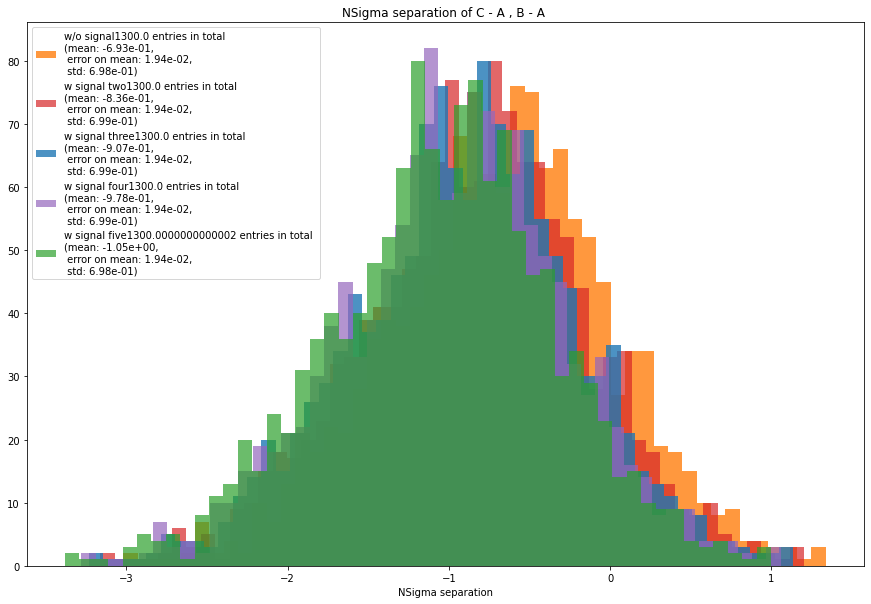

In [ ]:
def GenerateArrayLabel(arrArray):

  len_of_array = np.sum(arrArray)/np.mean(arrArray)
  mean_of_array = np.mean(arrArray)
  std_of_array = np.std(arrArray)
  mean_error_of_array = std_of_array/np.sqrt(len_of_array)

  #hist_label = str(len_of_array) + ' entries in total \n(mean: ' + str(mean_of_array) + ',\n error on mean: ' + str(mean_error_of_array) + ',\n std: ' + str(std_of_array) + ')'
  hist_label =  '{} entries in total \n(mean: {:.2e},\n error on mean: {:.2e},\n std: {:.2e})'.format(str(len_of_array), mean_of_array, mean_error_of_array, std_of_array)
  return hist_label

def CreateBinsForHistogram(arrEntries, bin_division = 1):

  # Gets the maximum and minimum values of the edges
  max_bin_ceil_value = np.max(arrEntries)
  min_bin_floor_value = np.min(arrEntries)
  
  # Calculates the number of bins needed
  num_of_bins = bin_division #bin_division * (max_bin_ceil_value - min_bin_floor_value) + 1
  
  arrBins = np.linspace(min_bin_floor_value, max_bin_ceil_value, num_of_bins)

  arrBinsCenters = np.array([0.5 * (arrBins[curr_index] + arrBins[curr_index + 1]) for curr_index in range(len(arrBins) - 1)])

  return arrBins, arrBinsCenters
  
hist_labelCB = GenerateArrayLabel(sep_DA_wo)
Bins_CB, BinsCenters_CB =  CreateBinsForHistogram(sep_DA_wo, bin_division = 50)

hist_labelCBSthree = GenerateArrayLabel(sep_DA_three)
Bins_CBSthree, BinsCenters_CBSthree =  CreateBinsForHistogram(sep_DA_three, bin_division = 50)

hist_labelCBSfive = GenerateArrayLabel(sep_DA_five)
Bins_CBSfive, BinsCenters_CBSfive =  CreateBinsForHistogram(sep_DA_five, bin_division = 50)

hist_labelCBStwo = GenerateArrayLabel(sep_DA_two)
Bins_CBStwo, BinsCenters_CBStwo =  CreateBinsForHistogram(sep_DA_two, bin_division = 50)

hist_labelCBSfour = GenerateArrayLabel(sep_DA_four)
Bins_CBSfour, BinsCenters_CBSfour =  CreateBinsForHistogram(sep_DA_four, bin_division = 50)

plt.hist(sep_DA_wo, bins=Bins_CB, label='w/o signal'+hist_labelCB, alpha=0.8,color='C1')
plt.hist(sep_DA_two, bins=Bins_CBStwo,label='w signal two'+ hist_labelCBStwo,alpha=0.7,color='C3')
plt.hist(sep_DA_three, bins=Bins_CBSthree,label= 'w signal three'+ hist_labelCBSthree,alpha=0.8,color='C0')
plt.hist(sep_DA_four, bins=Bins_CBSfour,label='w signal four'+ hist_labelCBSfour,alpha=0.7,color='C4')
plt.hist(sep_DA_five, bins=Bins_CBSfive,label='w signal five'+ hist_labelCBSfive,alpha=0.7,color='C2')
plt.legend()
plt.title('NSigma separation of C - A , B - A ')
plt.xlabel('NSigma separation')
plt.show()

In [ ]:
sep_one = []
sep_two = []
sep_one_two = []
sep_two_two = []
sep_one_four = []
sep_two_four = []
sep_one_five = []
sep_two_five = []
sep_one_three = []
sep_two_three = []

sep_one_next = []
sep_one_two_next = []
sep_one_four_next = []
sep_one_five_next = []
sep_one_three_next = []

def CalculateNSigmaavg(arrOneEntries, arrTwoEntries):

  arrDenominator = np.sqrt(arrTwoEntries)
  arrNumerator = np.subtract(arrOneEntries,arrTwoEntries)

  arrNSigma = (np.divide(arrNumerator, arrDenominator))
  arrNSigma = np.mean(arrNSigma)
  return arrNSigma

for i in range(50):
  C_entries = []
  D_entries = []
  DSfive_entries = []
  DSthree_entries = []
  DSfour_entries = []
  DStwo_entries = []
  


  NS_CA = []
  NS_DA = []
  NS_DB = []

  NS_DASfive = []
  NS_DASthree = []
  NS_DASfour = []
  NS_DAStwo = []
  
  NS_DBSfive = []
  NS_DBSthree =[]
  NS_DBSfour = []
  NS_DBStwo =[]

  NS_CA_next = []
  NS_DA_next = []

  NS_DASfive_next = []
  NS_DASthree_next = []
  NS_DASfour_next = []
  NS_DAStwo_next = []

  for y in range(12600):
    curr_C = np.random.poisson(np.random.normal(loc=A_entries[i], scale=np.sqrt(A_entries[i]),size = None))
    C_entries.append(curr_C)
    curr_D = np.random.poisson(np.random.normal(loc=B_entries[i], scale=np.sqrt(B_entries[i]),size = None))
    D_entries.append(curr_D)

    curr_Dtwo = np.random.poisson(np.random.normal(loc=B_two_sigma[i], scale=np.sqrt(B_two_sigma[i]),size = None))
    curr_Dthree = np.random.poisson(np.random.normal(loc=B_three_sigma[i], scale=np.sqrt(B_three_sigma[i]),size = None))
    curr_Dfour = np.random.poisson(np.random.normal(loc=B_four_sigma[i], scale=np.sqrt(B_four_sigma[i]),size = None))
    curr_Dfive = np.random.poisson(np.random.normal(loc=B_five_sigma[i], scale=np.sqrt(B_five_sigma[i]),size = None))

    DStwo_entries.append(curr_Dtwo)
    DSthree_entries.append(curr_Dthree)
    DSfour_entries.append(curr_Dfour)
    DSfive_entries.append(curr_Dfive)

    curr_NS_CA = CalculateNSigmaavg(curr_C,A_entries[i])
    curr_NS_DA = CalculateNSigmaavg(curr_D, A_entries[i])
    curr_NS_DB = CalculateNSigmaavg(curr_D, B_entries[i])

    curr_NS_DASfive = CalculateNSigmaavg(curr_Dfive, A_entries[i])
    curr_NS_DASthree = CalculateNSigmaavg(curr_Dthree, A_entries[i])

    curr_NS_DBSfive = CalculateNSigmaavg(curr_Dfive, B_entries[i])
    curr_NS_DBSthree = CalculateNSigmaavg(curr_Dthree, B_entries[i])
    
    curr_NS_DASfour = CalculateNSigmaavg(curr_Dfour, A_entries[i])
    curr_NS_DAStwo = CalculateNSigmaavg(curr_Dtwo, A_entries[i])
    
    curr_NS_DBSfour = CalculateNSigmaavg(curr_Dfour, B_entries[i])
    curr_NS_DBStwo = CalculateNSigmaavg(curr_Dtwo, B_entries[i])


    NS_CA.append(curr_NS_CA)
    NS_DA.append(curr_NS_DA)
    NS_DB.append(curr_NS_DB)
    
    NS_DASfive.append(curr_NS_DASfive)
    NS_DASthree.append(curr_NS_DASthree)
    NS_DBSfive.append(curr_NS_DBSfive)
    NS_DBSthree.append(curr_NS_DBSthree)
    
    NS_DASfour.append(curr_NS_DASfour)
    NS_DAStwo.append(curr_NS_DAStwo)
    NS_DBSfour.append(curr_NS_DBSfour)
    NS_DBStwo.append(curr_NS_DBStwo)

  curr_sep_one = (np.mean(NS_CA)-np.mean(NS_DA))/np.sqrt(np.std(NS_CA)**2 + np.std(NS_DA)**2)
  curr_sep_two = (np.mean(NS_CA)-np.mean(NS_DB))/np.sqrt(np.std(NS_CA)**2 + np.std(NS_DB)**2)
  sep_one.append(curr_sep_one)
  sep_two.append(curr_sep_two)

  curr_sep_one_five = (np.mean(NS_CA)-np.mean(NS_DASfive))/np.sqrt(np.std(NS_CA)**2 + np.std(NS_DASfive)**2)
  curr_sep_two_five = (np.mean(NS_CA)-np.mean(NS_DBSfive))/np.sqrt(np.std(NS_CA)**2 + np.std(NS_DBSfive)**2)
  sep_one_five.append(curr_sep_one_five)
  sep_two_five.append(curr_sep_two_five)
  
  curr_sep_one_three = (np.mean(NS_CA)-np.mean(NS_DASthree))/np.sqrt(np.std(NS_CA)**2 + np.std(NS_DASthree)**2)
  curr_sep_two_three = (np.mean(NS_CA)-np.mean(NS_DBSthree))/np.sqrt(np.std(NS_CA)**2 + np.std(NS_DBSthree)**2)
  sep_one_three.append(curr_sep_one_three)
  sep_two_three.append(curr_sep_two_three)
  
  curr_sep_one_four = (np.mean(NS_CA)-np.mean(NS_DASfour))/np.sqrt(np.std(NS_CA)**2 + np.std(NS_DASfour)**2)
  curr_sep_two_four = (np.mean(NS_CA)-np.mean(NS_DBSfour))/np.sqrt(np.std(NS_CA)**2 + np.std(NS_DBSfour)**2)
  sep_one_four.append(curr_sep_one_four)
  sep_two_four.append(curr_sep_two_four)
  
  curr_sep_one_two = (np.mean(NS_CA)-np.mean(NS_DAStwo))/np.sqrt(np.std(NS_CA)**2 + np.std(NS_DAStwo)**2)
  curr_sep_two_two = (np.mean(NS_CA)-np.mean(NS_DBStwo))/np.sqrt(np.std(NS_CA)**2 + np.std(NS_DBStwo)**2)
  sep_one_two.append(curr_sep_one_two)
  sep_two_two.append(curr_sep_two_two)
  
  #print(curr_sep_one, curr_sep_two)
  if i ==10: print(i)
  if i ==50: print(i)
  if i ==100: print(i)
  if i ==200: print(i)
  if i ==300: print(i)
  if i ==500: print(i)
  if i ==800: print(i)
  if i ==1100: print(i)

print(np.shape(sep_one)) 
    


10
(50,)


In [ ]:
POPT_GAUSSIAN_MEAN = 0
POPT_GAUSSIAN_STD = 1
POPT_GAUSSIAN_AMPLITUDE = 2

def Gaussian(x, mean, sigma, a):
  return a * np.exp(-((x - mean)**2 / (2 * sigma**2))) # 1/(np.sqrt(2 * np.pi) * sigma) * np.exp(-((x - mean)**2 / (2 * sigma**2)))

def PerformGaussianFit(arrXValues, arrYValues):

  proposed_a = np.max(arrYValues)
  proposed_mean = np.sum(arrXValues * arrYValues) / np.sum(arrYValues)
  propsed_std = np.sqrt(np.sum(arrYValues * (arrXValues - proposed_mean)**2) / np.sum(arrYValues))

  #print('proposed (a, mean, std): ', proposed_a, proposed_mean, propsed_std)

  popt, pcov = curve_fit(Gaussian, xdata = arrXValues, ydata = arrYValues, p0 = [proposed_mean, propsed_std, proposed_a])

  arrResiduals = arrYValues - Gaussian(arrXValues, *popt)

  return popt, pcov, arrResiduals

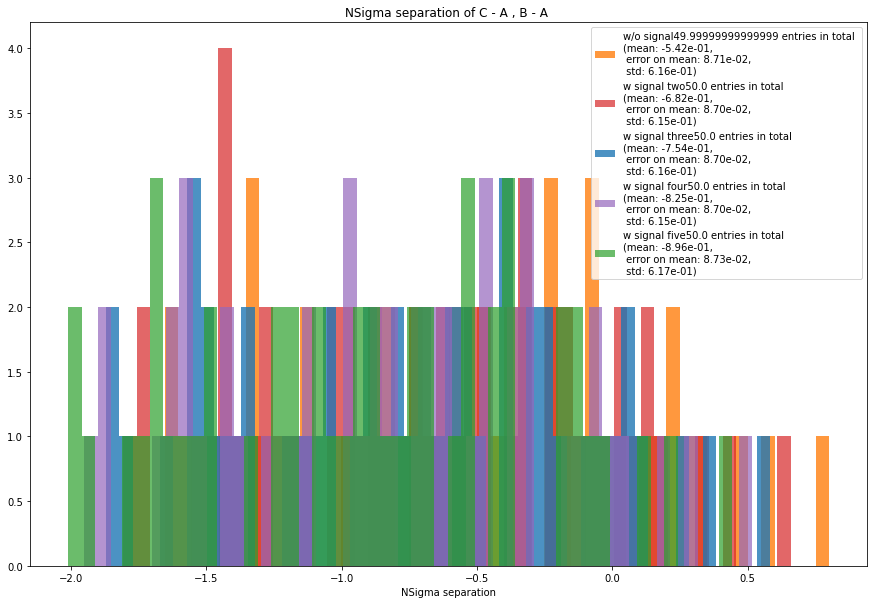

In [ ]:
def GenerateArrayLabel(arrArray):

  len_of_array = np.sum(arrArray)/np.mean(arrArray)
  mean_of_array = np.mean(arrArray)
  std_of_array = np.std(arrArray)
  mean_error_of_array = std_of_array/np.sqrt(len_of_array)

  #hist_label = str(len_of_array) + ' entries in total \n(mean: ' + str(mean_of_array) + ',\n error on mean: ' + str(mean_error_of_array) + ',\n std: ' + str(std_of_array) + ')'
  hist_label =  '{} entries in total \n(mean: {:.2e},\n error on mean: {:.2e},\n std: {:.2e})'.format(str(len_of_array), mean_of_array, mean_error_of_array, std_of_array)
  return hist_label

def CreateBinsForHistogram(arrEntries, bin_division = 1):

  # Gets the maximum and minimum values of the edges
  max_bin_ceil_value = np.max(arrEntries)
  min_bin_floor_value = np.min(arrEntries)
  
  # Calculates the number of bins needed
  num_of_bins = bin_division #bin_division * (max_bin_ceil_value - min_bin_floor_value) + 1
  
  arrBins = np.linspace(min_bin_floor_value, max_bin_ceil_value, num_of_bins)

  arrBinsCenters = np.array([0.5 * (arrBins[curr_index] + arrBins[curr_index + 1]) for curr_index in range(len(arrBins) - 1)])

  return arrBins, arrBinsCenters
  
hist_labelCB = GenerateArrayLabel(sep_one)
Bins_CB, BinsCenters_CB =  CreateBinsForHistogram(sep_one, bin_division = 50)

hist_labelCBSthree = GenerateArrayLabel(sep_one_three)
Bins_CBSthree, BinsCenters_CBSthree =  CreateBinsForHistogram(sep_one_three, bin_division = 50)

hist_labelCBSfive = GenerateArrayLabel(sep_one_five)
Bins_CBSfive, BinsCenters_CBSfive =  CreateBinsForHistogram(sep_one_five, bin_division = 50)

hist_labelCBStwo = GenerateArrayLabel(sep_one_two)
Bins_CBStwo, BinsCenters_CBStwo =  CreateBinsForHistogram(sep_one_two, bin_division = 50)

hist_labelCBSfour = GenerateArrayLabel(sep_one_four)
Bins_CBSfour, BinsCenters_CBSfour =  CreateBinsForHistogram(sep_one_four, bin_division = 50)

plt.hist(sep_one, bins=Bins_CB, label='w/o signal'+hist_labelCB, alpha=0.8,color='C1')
plt.hist(sep_one_two, bins=Bins_CBStwo,label='w signal two'+ hist_labelCBStwo,alpha=0.7,color='C3')
plt.hist(sep_one_three, bins=Bins_CBSthree,label= 'w signal three'+ hist_labelCBSthree,alpha=0.8,color='C0')
plt.hist(sep_one_four, bins=Bins_CBSfour,label='w signal four'+ hist_labelCBSfour,alpha=0.7,color='C4')
plt.hist(sep_one_five, bins=Bins_CBSfive,label='w signal five'+ hist_labelCBSfive,alpha=0.7,color='C2')
plt.legend()
plt.title('NSigma separation of C - A , B - A ')
plt.xlabel('NSigma separation')
plt.show()

####C v/sA and D v/s A

(12600,)
(12600,)
(12600,)
(12600,)
(12600,)
(12600,)


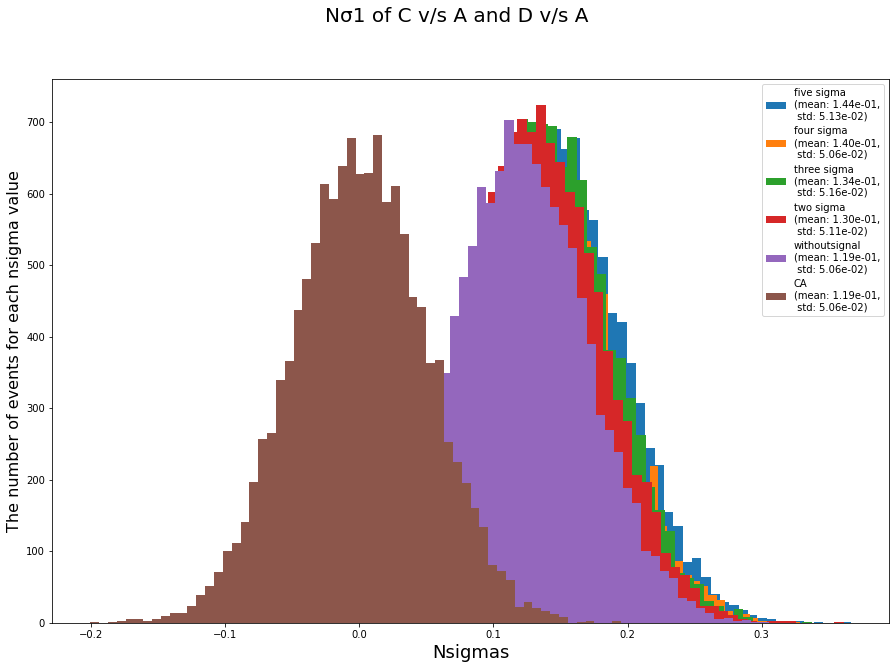

In [ ]:
import statistics


def Approximation(array):

  mean = np.mean(array)
  std = np.std(array)
  hist =  '\n(mean: {:.2e},\n std: {:.2e})'.format(mean,std)
  return hist
hist_five = Approximation(NS_DA_five)
hist_four = Approximation(NS_DA_four)
hist_three = Approximation(NS_DA_three)
hist_two = Approximation(NS_DA_two)
hist_wo = Approximation(NS_DA_wo)
hist = Approximation(NS_CA)
hist_s = Approximation(NS_DA_signal)

fig = plt.figure()
fig.suptitle('Nσ1 of C v/s A and D v/s A', fontsize=20)
plt.xlabel('Nsigmas', fontsize=18)
plt.ylabel('The number of events for each nsigma value', fontsize=16)
plt.hist(NS_DA_five,60, label='five sigma' + hist_five)
print(np.shape(NS_DA_five))

plt.hist(NS_DA_four,60, label='four sigma' + hist_four)
print(np.shape(NS_DA_four))

plt.hist(NS_DA_three,60, label='three sigma' + hist_three)
print(np.shape(NS_DA_three))

plt.hist(NS_DA_two,60, label='two sigma' + hist_two)
print(np.shape(NS_DA_two))

plt.hist(NS_DA_wo,60, label="withoutsignal" + hist_wo)
print(np.shape(NS_DA_wo))
plt.legend()

plt.hist(NS_CA,60, label="CA" + hist_wo)
print(np.shape(NS_DA_wo))
plt.legend()

#plt.hist(NS_CA,20, label="CA" + hist)
#print(np.shape(NS_CA))
#plt.legend()






/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

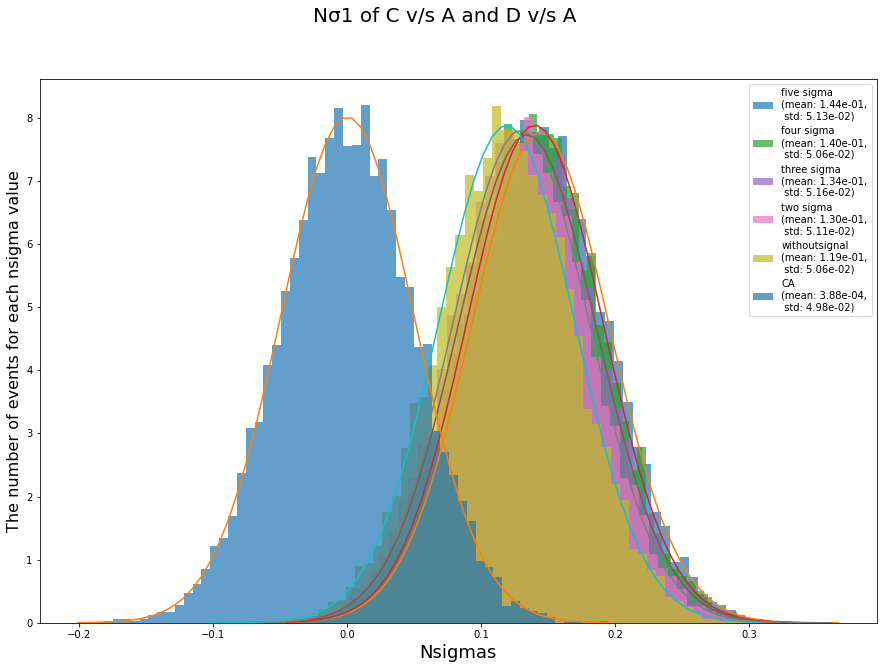

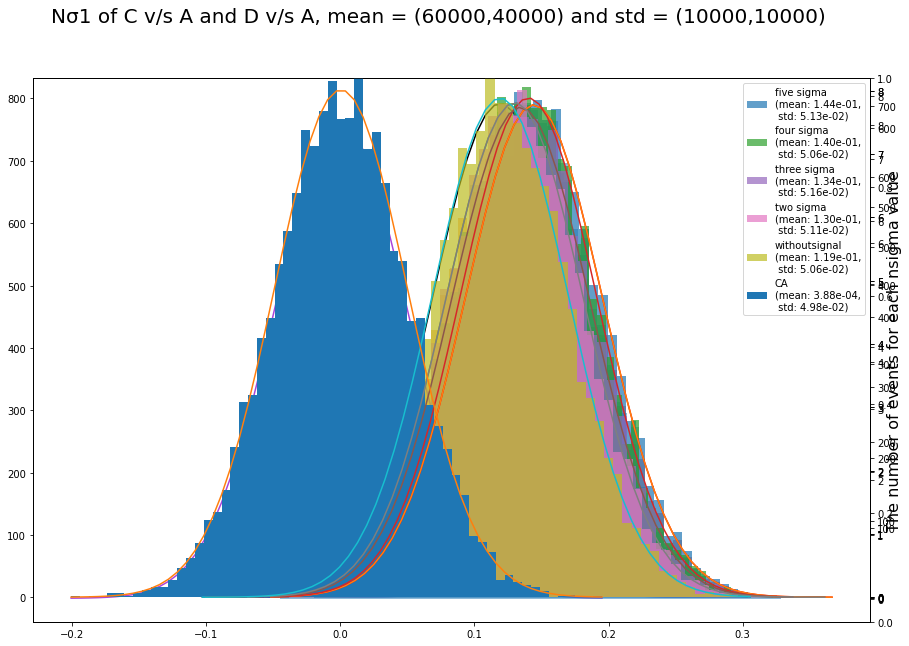

In [ ]:
import random

import scipy.stats as scs

fig = plt.figure()


data5 = NS_DA_five
_, bins5, _ = plt.hist(data5, 60, density=1,alpha=0.7, label='five sigma' + hist_five)
mu5, sigma5 = scs.norm.fit(data5)
best_fit_line5 = scs.norm.pdf(bins5, mu5, sigma5)
plt.plot(bins5, best_fit_line5)
fig.suptitle('Nσ1 of C v/s A and D v/s A', fontsize=20)
plt.xlabel('Nsigmas', fontsize=18)
plt.ylabel('The number of events for each nsigma value', fontsize=16)
fig.savefig('73.jpg')

data4 = NS_DA_four
_, bins4, _ = plt.hist(data4, 60, density=1,alpha=0.7, label='four sigma' + hist_four)
mu4, sigma4 = scs.norm.fit(data4)
best_fit_line4 = scs.norm.pdf(bins4, mu4, sigma4)
plt.plot(bins4, best_fit_line4)

data3 = NS_DA_three
_, bins3, _ = plt.hist(data3, 60,density=1,alpha=0.7, label='three sigma' + hist_three)
mu3, sigma3 = scs.norm.fit(data3)
best_fit_line3 = scs.norm.pdf(bins3, mu3, sigma3)
plt.plot(bins3, best_fit_line3)

data2 = NS_DA_two
_, bins2, _ = plt.hist(data2, 60, density=1, alpha=0.7, label='two sigma' + hist_two)
mu2, sigma2 = scs.norm.fit(data2)
best_fit_line2 = scs.norm.pdf(bins2, mu2, sigma2)
plt.plot(bins2, best_fit_line2)

datawo = NS_DA_wo
_, binswo, _ = plt.hist(datawo, 60,density=1,alpha=0.7, label="withoutsignal" + hist_wo)
muwo, sigmawo = scs.norm.fit(datawo)
best_fit_linewo = scs.norm.pdf(binswo, muwo, sigmawo)
plt.plot(binswo, best_fit_linewo)
plt.legend()

data = NS_CA
_, bins, _ = plt.hist(data, 60,density=1,alpha=0.7, label="CA" + hist)
mu, sigma = scs.norm.fit(data)
best_fit_line = scs.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)
plt.legend()





def align_yaxis_np(ax1, ax2):
    """Align zeros of the two axes, zooming them out by same ratio"""
    axes = np.array([ax1, ax2])
    extrema = np.array([ax.get_ylim() for ax in axes])
    tops = extrema[:,1] / (extrema[:,1] - extrema[:,0])
    # Ensure that plots (intervals) are ordered bottom to top:
    if tops[0] > tops[1]:
        axes, extrema, tops = [a[::-1] for a in (axes, extrema, tops)]

    # How much would the plot overflow if we kept current zoom levels?
    tot_span = tops[1] + 1 - tops[0]

    extrema[0,1] = extrema[0,0] + tot_span * (extrema[0,1] - extrema[0,0])
    extrema[1,0] = extrema[1,1] + tot_span * (extrema[1,0] - extrema[1,1])
    [axes[i].set_ylim(*extrema[i]) for i in range(2)]




r = random.random()
b = random.random()
g = random.random()
color = (r, g, b)
fig = plt.figure()
axCA1 = fig.add_subplot(111)
axCA2 = axCA1.twinx()
axwo1 = fig.add_subplot(111)
axwo2 = axwo1.twinx()
ax11 = fig.add_subplot(111)
ax12 = ax11.twinx()
ax21 = fig.add_subplot(111)
ax22 = ax21.twinx()
ax31 = fig.add_subplot(111)
ax32 = ax31.twinx()
ax41 = fig.add_subplot(111)
ax42 = ax41.twinx()
ax51 = fig.add_subplot(111)
ax52 = ax51.twinx()

axCA1.hist(data,60,alpha = 0.5,label="CA" + hist)
axCA2.plot(bins,best_fit_line,c=color)
axwo1.hist(datawo,60,alpha = 0.5)
axwo2.plot(binswo,best_fit_linewo,c='black')
ax21.hist(data2,60,alpha = 0.5)
ax22.plot(bins2,best_fit_line2,c='g')
ax32.hist(data3,60,alpha = 0.5)
ax31.plot(bins3,best_fit_line3,c='blue')
ax42.hist(data4,60,alpha = 0.5)
ax41.plot(bins4,best_fit_line4,c='pink')
ax51.hist(data5,60,alpha = 0.5)
ax52.plot(bins5,best_fit_line5,c='r')
plt.legend()
align_yaxis_np(axCA1,axCA2)
align_yaxis_np(axwo1,axwo2)
align_yaxis_np(ax21,ax22)
align_yaxis_np(ax31,ax32)
align_yaxis_np(ax41,ax42)
align_yaxis_np(ax51,ax52)

data5 = NS_DA_five
_, bins5, _ = plt.hist(data5, 60, density=1,alpha=0.7, label='five sigma' + hist_five)
mu5, sigma5 = scs.norm.fit(data5)
best_fit_line5 = scs.norm.pdf(bins5, mu5, sigma5)
plt.plot(bins5, best_fit_line5)
fig.suptitle('Nσ1 of C v/s A and D v/s A, mean = (60000,40000) and std = (10000,10000)', fontsize=20)
plt.xlabel('Nsigmas', fontsize=18)
plt.ylabel('The number of events for each nsigma value', fontsize=16)
fig.savefig('73.jpg')

data4 = NS_DA_four
_, bins4, _ = plt.hist(data4, 60, density=1,alpha=0.7, label='four sigma' + hist_four)
mu4, sigma4 = scs.norm.fit(data4)
best_fit_line4 = scs.norm.pdf(bins4, mu4, sigma4)
plt.plot(bins4, best_fit_line4)

data3 = NS_DA_three
_, bins3, _ = plt.hist(data3, 60,density=1,alpha=0.7, label='three sigma' + hist_three)
mu3, sigma3 = scs.norm.fit(data3)
best_fit_line3 = scs.norm.pdf(bins3, mu3, sigma3)
plt.plot(bins3, best_fit_line3)

data2 = NS_DA_two
_, bins2, _ = plt.hist(data2, 60, density=1, alpha=0.7, label='two sigma' + hist_two)
mu2, sigma2 = scs.norm.fit(data2)
best_fit_line2 = scs.norm.pdf(bins2, mu2, sigma2)
plt.plot(bins2, best_fit_line2)

datawo = NS_DA_wo
_, binswo, _ = plt.hist(datawo, 60,density=1,alpha=0.7, label="withoutsignal" + hist_wo)
muwo, sigmawo = scs.norm.fit(datawo)
best_fit_linewo = scs.norm.pdf(binswo, muwo, sigmawo)
plt.plot(binswo, best_fit_linewo)
plt.legend()

data = NS_CA
_, bins, _ = plt.hist(data, 60,density=1,alpha=1, label="CA" + hist)
mu, sigma = scs.norm.fit(data)
best_fit_line = scs.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)
plt.legend()


plt.show()

In [ ]:
NS_CAAA = []
NS_DAAA = []

NS_DASfiveAA = []
NS_DASthreeAA = []
NS_DASfourAA = []
NS_DAStwoAA = []
 
for x in range(1):
 NS_CAA = []
 NS_DAA = []

 NS_DASfiveA = []
 NS_DASthreeA = []
 NS_DASfourA = []
 NS_DAStwoA = []

 for i in range(500):
   C_entries = []
   D_entries = []
   DSfive_entries = []
   DSthree_entries = []
   DSfour_entries = []
   DStwo_entries = []
  


   NS_CA = []
   NS_DA = []
   
   NS_DASfive = []
   NS_DASthree = []
   NS_DASfour = []
   NS_DAStwo = []
  
   for y in range(12600):
     curr_C = np.random.poisson(np.random.normal(loc=A_entries[i], scale=np.sqrt(A_entries[i]),size = None))
     C_entries.append(curr_C)
     curr_D = np.random.poisson(np.random.normal(loc=B_entries[i], scale=np.sqrt(B_entries[i]),size = None))
     D_entries.append(curr_D)

     curr_Dtwo = np.random.poisson(np.random.normal(loc=B_two_sigma[i], scale=np.sqrt(B_two_sigma[i]),size = None))
     curr_Dthree = np.random.poisson(np.random.normal(loc=B_three_sigma[i], scale=np.sqrt(B_three_sigma[i]),size = None))
     curr_Dfour = np.random.poisson(np.random.normal(loc=B_four_sigma[i], scale=np.sqrt(B_four_sigma[i]),size = None))
     curr_Dfive = np.random.poisson(np.random.normal(loc=B_five_sigma[i], scale=np.sqrt(B_five_sigma[i]),size = None))

     DStwo_entries.append(curr_Dtwo)
     DSthree_entries.append(curr_Dthree)
     DSfour_entries.append(curr_Dfour)
     DSfive_entries.append(curr_Dfive)

     curr_NS_CA = CalculateNSigmaavg(curr_C,A_entries[i])
     curr_NS_DA = CalculateNSigmaavg(curr_D, A_entries[i])

     curr_NS_DASfive = CalculateNSigmaavg(curr_Dfive, A_entries[i])
     curr_NS_DASthree = CalculateNSigmaavg(curr_Dthree, A_entries[i])
    
     curr_NS_DASfour = CalculateNSigmaavg(curr_Dfour, A_entries[i])
     curr_NS_DAStwo = CalculateNSigmaavg(curr_Dtwo, A_entries[i])
    


     NS_CA.append(curr_NS_CA)
     NS_DA.append(curr_NS_DA)
    
     NS_DASfive.append(curr_NS_DASfive)
     NS_DASthree.append(curr_NS_DASthree)
    
     NS_DASfour.append(curr_NS_DASfour)
     NS_DAStwo.append(curr_NS_DAStwo)

   NS_CAA = NS_CAA + NS_CA
   NS_DAA = NS_DAA + NS_DA
   NS_DASfiveA = NS_DASfiveA + NS_DASfive
   NS_DASfourA = NS_DASfourA + NS_DASfour
   NS_DASthreeA = NS_DASthreeA + NS_DASthree
   NS_DAStwoA = NS_DAStwoA + NS_DAStwo
   if i ==10: print(i)
   if i ==50: print(i)
   if i ==100: print(i)
   if i ==200: print(i)
   if i ==300: print(i)
   if i ==500: print(i)
   if i ==800: print(i)
   if i ==1100: print(i)
 print(x) 

10
50
100
200
300


In [ ]:
def GenerateArrayLabel(arrArray):

  len_of_array = np.sum(arrArray)/np.mean(arrArray)
  mean_of_array = np.mean(arrArray)
  std_of_array = np.std(arrArray)
  mean_error_of_array = std_of_array/np.sqrt(len_of_array)

  #hist_label = str(len_of_array) + ' entries in total \n(mean: ' + str(mean_of_array) + ',\n error on mean: ' + str(mean_error_of_array) + ',\n std: ' + str(std_of_array) + ')'
  hist_label =  '{} entries in total \n(mean: {:.2e},\n error on mean: {:.2e},\n std: {:.2e})'.format(str(len_of_array), mean_of_array, mean_error_of_array, std_of_array)
  return hist_label

def CreateBinsForHistogram(arrEntries, bin_division = 1):

  # Gets the maximum and minimum values of the edges
  max_bin_ceil_value = np.max(arrEntries)
  min_bin_floor_value = np.min(arrEntries)
  
  # Calculates the number of bins needed
  num_of_bins = bin_division #bin_division * (max_bin_ceil_value - min_bin_floor_value) + 1
  
  arrBins = np.linspace(min_bin_floor_value, max_bin_ceil_value, num_of_bins)

  arrBinsCenters = np.array([0.5 * (arrBins[curr_index] + arrBins[curr_index + 1]) for curr_index in range(len(arrBins) - 1)])

  return arrBins, arrBinsCenters
  
hist_labelCB = GenerateArrayLabel(np.abs(NS_CAA))
Bins_CB, BinsCenters_CB =  CreateBinsForHistogram(np.abs(NS_CAA), bin_division = 50)

hist_labelCBSthree = GenerateArrayLabel(np.abs(NS_DASthreeA))
Bins_CBSthree, BinsCenters_CBSthree =  CreateBinsForHistogram(np.abs(NS_DASthreeA), bin_division = 50)

hist_labelCBSfive = GenerateArrayLabel(np.abs(NS_DASfiveA))
Bins_CBSfive, BinsCenters_CBSfive =  CreateBinsForHistogram(np.abs(NS_DASfiveA), bin_division = 50)

hist_labelCBStwo = GenerateArrayLabel(np.abs(NS_DAStwoA))
Bins_CBStwo, BinsCenters_CBStwo =  CreateBinsForHistogram(np.abs(NS_DAStwoA), bin_division = 50)

hist_labelCBSfour = GenerateArrayLabel(np.abs(NS_DASfourA))
Bins_CBSfour, BinsCenters_CBSfour =  CreateBinsForHistogram(np.abs(NS_DASfourA), bin_division = 50)

plt.hist(np.abs(NS_CAA), bins=Bins_CB, label='w/o signal'+hist_labelCB, alpha=0.8,color='C1')
plt.hist(np.abs(NS_DAStwoA), bins=Bins_CBStwo,label='w signal two'+ hist_labelCBStwo,alpha=0.7,color='C3')
plt.hist(np.abs(NS_DASthreeA), bins=Bins_CBSthree,label= 'w signal three'+ hist_labelCBSthree,alpha=0.8,color='C0')
plt.hist(np.abs(NS_DASfourA), bins=Bins_CBSfour,label='w signal four'+ hist_labelCBSfour,alpha=0.7,color='C4')
plt.hist(np.abs(NS_DASfiveA), bins=Bins_CBSfive,label='w signal five'+ hist_labelCBSfive,alpha=0.7,color='C2')
plt.legend()
plt.title('NSigma separation of C - A , B - A ')
plt.xlabel('NSigma separation')
plt.show()

In [ ]:
count = []
count_D = []
count_s_two = []
count_s_four = []
count_s_three = []
count_s_five = []
x = 0.0
while x < 0.31:
  curr_count = 0
  curr_count_D = 0
  curr_count_s_two =0
  curr_count_s_four = 0
  curr_count_s_three = 0
  curr_count_s_five = 0
  for j in range(126000):
    if np.abs(NS_CAA[j]) >= x :
      curr_count = curr_count+1
    if np.abs(NS_DAA[j]) >=x:
      curr_count_D = curr_count_D+1
    if np.abs(NS_DASthreeA[j]) >= x :
      curr_count_s_three = curr_count_s_three+1
    if np.abs(NS_DASfiveA[j]) >= x :
      curr_count_s_five = curr_count_s_five+1
    if np.abs(NS_DASfourA[j]) >= x :
      curr_count_s_four = curr_count_s_four+1  
    if np.abs(NS_DAStwoA[j]) >= x :
      curr_count_s_two = curr_count_s_two+1  
      
  x = x + 0.005
  count.append(curr_count)
  count_D.append(curr_count_D)
  count_s_three.append(curr_count_s_three)
  count_s_five.append(curr_count_s_five)
  count_s_four.append(curr_count_s_four)
  count_s_two.append(curr_count_s_two)

In [ ]:
for i in range(1):
  count_new = np.divide(count,126000)*100
  count_D_new = np.divide(count_D,126000)*100
  count_s_three_new = np.divide(count_s_three,126000)*100
  count_s_five_new = np.divide(count_s_five,126000)*100
  count_s_two_new = np.divide(count_s_two,126000)*100
  count_s_four_new = np.divide(count_s_four,126000)*100

  plt.plot(count_new,count_D_new, linestyle='--', marker = 'o', color = 'y', label = 'no signal')
  plt.plot(count_new,count_s_two_new, linestyle='--', marker = 'o', color = 'r', label = '2 sigma')
  plt.plot(count_new,count_s_three_new, linestyle='--', marker = 'o', color = 'g', label = '3 sigma')
  plt.plot(count_new,count_s_four_new, linestyle='--', marker = 'o', color = 'b', label = '4 sigma')
  plt.plot(count_new,count_s_five_new, linestyle='--', marker = 'o', color = 'c', label = '5 sigma')

  plt.legend()
  plt.grid()
  plt.xlim(0.0)
  plt.ylim(0.0)
  plt.xlabel('w/o signal')
  plt.ylabel('w signal')
  plt.title('Separation comparison')